NAMA: KOMANG JAYA BHASKARA MAHATYA
NIM : 1103181031
WEEK 11 - LeNet Tensorflow

In [ ]:
import pandas as pd
#import tensorflow as tf

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Machine Learning with Mr. Risman Adnan/Week 11/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Machine Learning with Mr. Risman Adnan/Week 11/test.csv")
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
train_x, valid_x, train_y, valid_y = train_test_split(train.iloc[:,1:], 
                                                      train.iloc[:,0], 
                                                      test_size=0.1)
print("Training set size: {}".format(train_x.shape))
print("Validation set size: {}".format(valid_x.shape))
print("Test set size: {}".format(test.shape))

Training set size: (37800, 784)
Validation set size: (4200, 784)
Test set size: (28000, 784)


In [ ]:
# Normalise all columns
# The network will converge faster with normalized values.
train_x = train_x.apply(lambda x : x / 255)
valid_x = valid_x.apply(lambda x: x / 255)
test = test.apply(lambda x: x / 255)

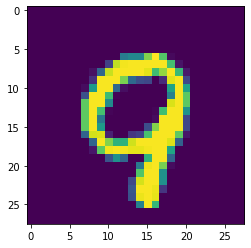

In [ ]:
# Example training data
plt.imshow(train_x.iloc[5].values.reshape(28, 28))

In [ ]:
# LeNet-5 Model architecture
def model(train_x, train_y, valid_x, valid_y, test_x, learning_rate=0.0001, batch_size=128, num_epochs=1000):
    
    # Create placeholder for model input and label.
    # Input shape is (minbatch_size, 28, 28)
    X = tf.placeholder(tf.float32, [None, 28, 28], name="X")
    Y = tf.placeholder(tf.int64, [None, ], name="Y")
    
    def CNN(X):
        # Here we defind the CNN architecture (LeNet-5)
        
        # Reshape input to 4-D vector
        input_layer = tf.reshape(X, [-1, 28, 28, 1]) # -1 adds minibatch support.
        
        # Padding the input to make it 32x32. Specification of LeNET
        padded_input = tf.pad(input_layer, [[0, 0], [2, 2], [2, 2], [0, 0]], "CONSTANT") 
        
        # Convolutional Layer #1
        # Has a default stride of 1
        # Output: 28 * 28 * 6
        conv1 = tf.layers.conv2d(
          inputs=padded_input,
          filters=6, # Number of filters.
          kernel_size=5, # Size of each filter is 5x5.
          padding="valid", # No padding is applied to the input.
          activation=tf.nn.relu)

        # Pooling Layer #1
        # Sampling half the output of previous layer
        # Output: 14 * 14 * 6
        pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

        # Convolutional Layer #2
        # Output: 10 * 10 * 16
        conv2 = tf.layers.conv2d(
          inputs=pool1,
          filters=16, # Number of filters
          kernel_size=5, # Size of each filter is 5x5
          padding="valid", # No padding
          activation=tf.nn.relu)

        # Pooling Layer #2
        # Output: 5 * 5 * 16
        pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

        # Reshaping output into a single dimention array for input to fully connected layer
        pool2_flat = tf.reshape(pool2, [-1, 5 * 5 * 16])

        # Fully connected layer #1: Has 120 neurons
        dense1 = tf.layers.dense(inputs=pool2_flat, units=120, activation=tf.nn.relu)

        # Fully connected layer #2: Has 84 neurons
        dense2 = tf.layers.dense(inputs=dense1, units=84, activation=tf.nn.relu)

        # Output layer, 10 neurons for each digit
        logits = tf.layers.dense(inputs=dense2, units=10)
        
        return logits
    
    # Pass the input thorough our CNN
    logits = CNN(X)
    softmax = tf.nn.softmax(logits)
    
    # Convert our labels into one-hot-vectors
    labels = tf.one_hot(indices=tf.cast(Y, tf.int32), depth=10)
    
    # Compute the cross-entropy loss
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,
                                                                     labels=labels))
    
    # Use adam optimizer to reduce cost
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(cost)
    
    
    # For testing and prediction
    predictions = tf.argmax(softmax, axis=1)
    correct_prediction = tf.equal(predictions, Y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    
    # Initialize all the variables
    init = tf.global_variables_initializer()
    
    
    # Running the model
    with tf.Session() as sess:
 
        sess.run(init)
        
        for epoch in range(num_epochs):
            num_samples = train_x.shape[0]
            num_batches = (num_samples // batch_size) + 1
            epoch_cost = 0.
            i = 0
            while i < num_samples:
                batch_x = train_x.iloc[i:i+batch_size,:].values
                batch_x = batch_x.reshape(batch_x.shape[0], 28, 28)

                batch_y = train_y.iloc[i:i+batch_size].values

                i += batch_size

                # Train on batch and get back cost
                _, c = sess.run([train_op, cost], feed_dict={X:batch_x, Y:batch_y})
                epoch_cost += (c/num_batches)
                
            # Get accuracy for validation
            valid_accuracy = accuracy.eval(
                feed_dict={X:valid_x.values.reshape(valid_x.shape[0], 28, 28),
                           Y:valid_y.values})
            
            print ("Epoch {}: Cost: {}".format(epoch+1, epoch_cost))
            print("Validation accuracy: {}".format(valid_accuracy))
            
        return predictions.eval(feed_dict={X:test_x.values.reshape(test_x.shape[0], 28, 28)})

In [ ]:
# Run for more epochs for better accuracy
predictions = model(train_x, train_y, valid_x, valid_y, test, learning_rate=0.0001, batch_size=64, num_epochs=5)

# Examples of what predictions look like
print("First 5 test predictions: {}".format(predictions[:5]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/convolutional.py:575: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: `tf.layers.max_pooling2d` is deprecated and will be removed in a future version. Please use `tf.keras.layers.MaxPooling2D` instead.
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/pooling.py:600: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: `tf.layers.conv2d` is deprecated and will b

Epoch 1: Cost: 0.9061632364131063
Validation accuracy: 0.9064285755157471
Epoch 2: Cost: 0.2632662102252294
Validation accuracy: 0.9345238208770752
Epoch 3: Cost: 0.19204861895762723
Validation accuracy: 0.947857141494751
Epoch 4: Cost: 0.15237966193715113
Validation accuracy: 0.9571428298950195
Epoch 5: Cost: 0.12712875112903804
Validation accuracy: 0.9649999737739563
First 5 test predictions: [2 0 9 7 3]
